# Implémentez un modèle de scoring

*Notebook modélisation - partie analyse et feature engineering*

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

**Mission :**

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

- Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.

- Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.

- Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.
    + Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations
    + Lancer l’interface web 'UI MLFlow" d'affichage des résultats du tracking
    + Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”
    + Tester le serving MLFlow
    + Gérer le code avec le logiciel de version Git
    + Partager le code sur Github pour assurer une intégration continue
    + Utiliser Github Actions pour le déploiement continu et automatisé du code de l’API sur le cloud
    + Concevoir des tests unitaires avec Pytest (ou Unittest) et les exécuter de manière automatisée lors du build réalisé par Github Actions

## 1 - Préparer l'environnement d'expérimentation

### 1.1 - Imports

In [3]:
import mlflow
import mlflow.tracking
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate

from imblearn.over_sampling import SMOTE

from contextlib import contextmanager
import time

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("mlflow version", mlflow.__version__)
print("sklearn version", sklearn.__version__)

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 200
pd.options.display.max_columns = 130

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
mlflow version 2.20.1
sklearn version 1.6.1


### 1.2 - Lancement du serveur MLFlow

Dans le terminal de Powershell Prompt d'Anaconda, lancer cette instruction :

mlflow server --host 127.0.0.1 --port 5000 --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns

Cette commande permet de :
- Stocker les métadonnées du Model Registry dans une base de données locale SQLite.
- Stocker les artefacts (modèles, fichiers) en local.

### 1.3 - Initialisation du Tracking MLFlow de test

In [6]:
import os

# Ignorer Git
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

# Vérification si la variable d'environnement est bien définie
print(os.environ.get('GIT_PYTHON_REFRESH'))

quiet


In [7]:
# Définir le serveur de tracking (local ou distant) - ici local
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Démarrer une nouvelle expérimentation
mlflow.set_experiment("modele_test_quickstart_2")

<Experiment: artifact_location='file:///C:/Users/admin/mlruns/8', creation_time=1739109022738, experiment_id='8', last_update_time=1739109022738, lifecycle_stage='active', name='modele_test_quickstart_2', tags={}>

### 1.4 - Création d'un modèle pour tester l'initialisation

In [9]:
# Charger les données Iris (pour la démonstration)
data = load_iris()
X = data.data
y = data.target

# Diviser les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model hyperparameters
params = {
    "random_state": 42,
}

# Initialiser le modèle
model = LogisticRegression(**params)

# Entraînement du modèle
model.fit(X_train, y_train)
    
# Faire des prédictions sur le jeu de test
y_pred = model.predict(X_test)
#y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilités pour AUC binaire
y_pred_prob = model.predict_proba(X_test)  # Probabilités pour AUC

# Calculer accuracy et AUC
accuracy = accuracy_score(y_test, y_pred)
# auc = roc_auc_score(y_test, y_pred_prob) --> si le problème était binaire
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')

### 1.5 - Enregistrer le modèle et ses métadonnées dans MLFlow

Créons une fonction :

In [11]:
def tracking_mlflow(tag, model, params, metrics, registered_model_name, X_train):

    # Démarrer une expérimentation dans MLflow
    with mlflow.start_run():
    
        # Log the hyperparameters
        mlflow.log_params(params)
        
        # Loguer les métriques
        for key, value in metrics.items():
            mlflow.log_metric(key, value)
            #mlflow.log_metric("accuracy", accuracy)
            #mlflow.log_metric("auc", auc)
    
        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag(tag[0], tag[1])
    
        # Infer the model signature
        signature = infer_signature(X_train, model.predict(X_train))
        
        # Loguer le modèle
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="iris_model",
            signature=signature,
            input_example=X_train,
            registered_model_name=registered_model_name,
        )

        for key, value in metrics.items():
            print(key, ":" , value)
    
    print(f"Modèle enregistré en version {model_info.mlflow_version}")

    return model_info

In [12]:
metrics = {"accuracy": accuracy, "auc": auc}
registered_model_name="modele_test_quickstart_2"
tag = "Training Info", "Basic LR model for iris data"

model_info = tracking_mlflow(tag, model, params, metrics, registered_model_name, X_train)

Registered model 'modele_test_quickstart_2' already exists. Creating a new version of this model...
2025/02/14 09:21:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modele_test_quickstart_2, version 16


accuracy : 1.0
auc : 1.0
🏃 View run fun-fox-69 at: http://127.0.0.1:5000/#/experiments/8/runs/805803094e6e4a64b96966205f20fb3e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/8
Modèle enregistré en version 2.20.1


Created version '16' of model 'modele_test_quickstart_2'.


**Lister les versions du modèle**

In [14]:
client = mlflow.tracking.MlflowClient()
versions = client.get_latest_versions("modele_test_quickstart_2")
for v in versions:
    print(f"Version: {v.version}, Statut: {v.current_stage}")

Version: 16, Statut: None


### 1.6 - Chargez le modèle en tant que fonction Python, et l'utiliser pour une prédiction

In [16]:
from sklearn import datasets

# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

predictions = loaded_model.predict(X_test)

iris_feature_names = datasets.load_iris().feature_names

result = pd.DataFrame(X_test, columns=iris_feature_names)
result["actual_class"] = y_test
result["predicted_class"] = predictions

result[:4]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),actual_class,predicted_class
0,6.1,2.8,4.7,1.2,1,1
1,5.7,3.8,1.7,0.3,0,0
2,7.7,2.6,6.9,2.3,2,2
3,6.0,2.9,4.5,1.5,1,1


### 1.7 - Lancement de l'UI

Pour  la visualisation et la comparaison des expérimentations, ainsi que le stockage de manière centralisée des modèles.

Cliquer sur ce lien : http://127.0.0.1:5000/

## 2 - Analyser le jeu de données

Je suis le kernel suivant : https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook

### 2.1 - Charger les données du fichier application_train

Le fichier application_test n'est pas utile, car il est destiné au concours Kaggle. Il ne contient pas la variable cible.

In [19]:
# Training data
app_train = pd.read_csv('C:/Users/admin/Documents/Projets/Projet_7/data_projet/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict)

### 2.2 - Analyser la distribution de la variable cible TARGET

In [22]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

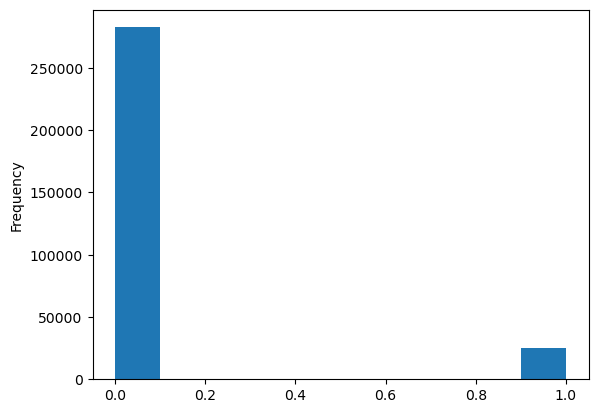

In [23]:
app_train['TARGET'].astype(int).plot.hist();

Il y a un déséquilibre important entre les 2 classes :
- 0 : le prêt a été remboursé
- 1 : le prêt n'a pas été remboursé.

Il y a plus de prêts remboursés que de prêts non remboursés.

### 2.3 - Examiner les valeurs manquantes

In [26]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [27]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(70)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


### 2.4 - Examiner les types de colonnes

In [29]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

Regardons le nombre de valeurs uniques dans les colonnes de type object:

In [31]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques. Nous devons transformer ces catégories en variable numérique via un processus d'encodage : étiquettes (label) versus one-hot.

Le problème avec le codage des étiquettes est qu'il donne aux catégories un ordre arbitraire.

Nous utiliserons le codage d'étiquettes (Binary encode) pour toutes les variables catégorielles avec seulement 2 catégories, et le codage one-hot (get_dummies de pandas) pour toutes les variables catégorielles avec plus de 2 catégories.

### 2.6 - Recherche des valeurs aberrantes

In [34]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

Les valeurs DAYS_xxx sont négatives car elles sont enregistrés par rapport à la demande de prêt en cours. Elles seront traitées dans le feature engineering.

**La valeur max deLa variable DAYS_EMPLOYED contient des valeurs aberrantes :**

In [36]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

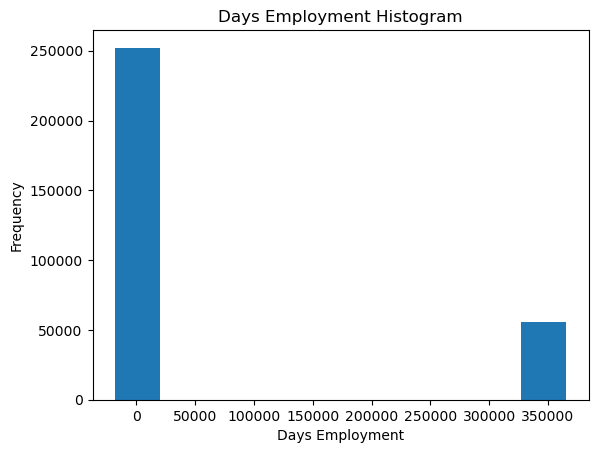

In [37]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [38]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Les anomalies ont un taux de défaut plus faible.

Puisque toutes les anomalies ont exactement la même valeur, nous voulons les remplir avec la même valeur au cas où tous ces prêts partageraient quelque chose en commun. En guise de solution, nous allons remplir les valeurs anormales avec un nombre (np.nan) lors du feature engineering.

### 2.7 - Corrélations

In [41]:
# Find correlations with the target and sort
correlations = app_train.select_dtypes(include=['number']).corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


In [42]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Il existe une relation linéaire négative avec la cible, ce qui signifie qu'à mesure que les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps plus souvent.

Commençons par examiner cette variable. Tout d'abord, nous pouvons créer un histogramme de l'âge. Nous mettrons l'axe des x en années pour rendre le tracé un peu plus compréhensible.

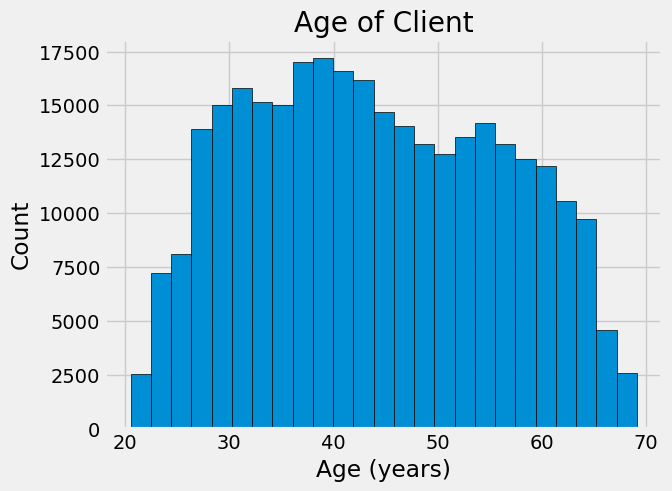

In [44]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite créer un graphique d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible. 

Un graphique d'estimation de la densité du noyau montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement un gaussien, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). 

Nous utiliserons le kdeplot de Seaborn pour ce graphique.

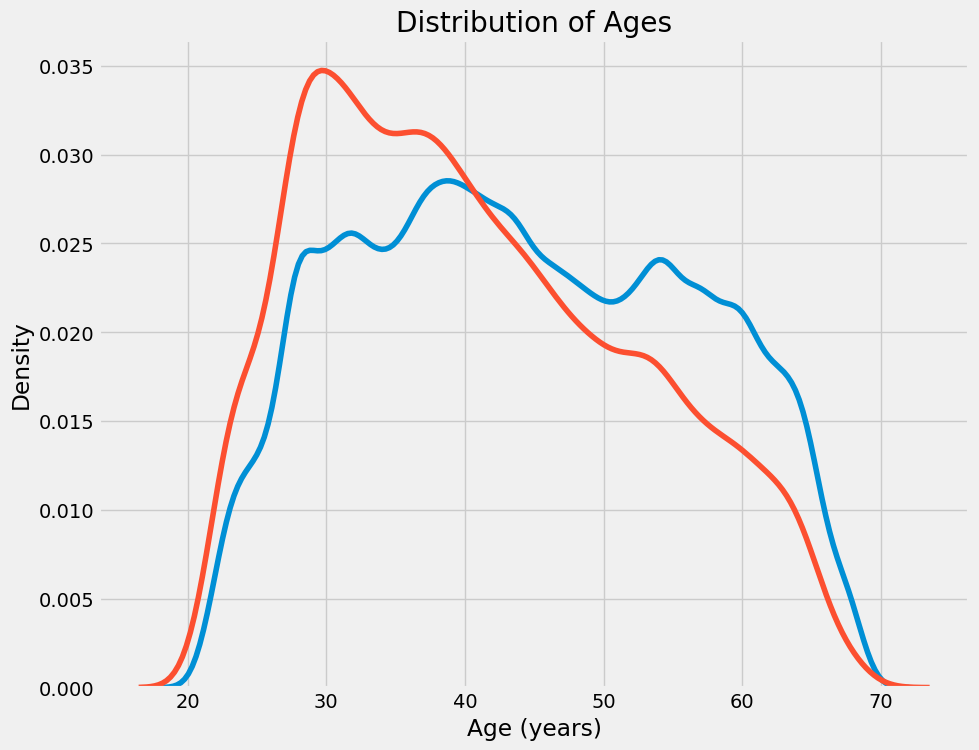

In [46]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe cible == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien que cette corrélation ne soit pas significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation d'une autre manière : le taux moyen de non-remboursement des prêts par tranche d'âge.

Pour réaliser ce graphique, nous découpons d'abord la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [48]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [49]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


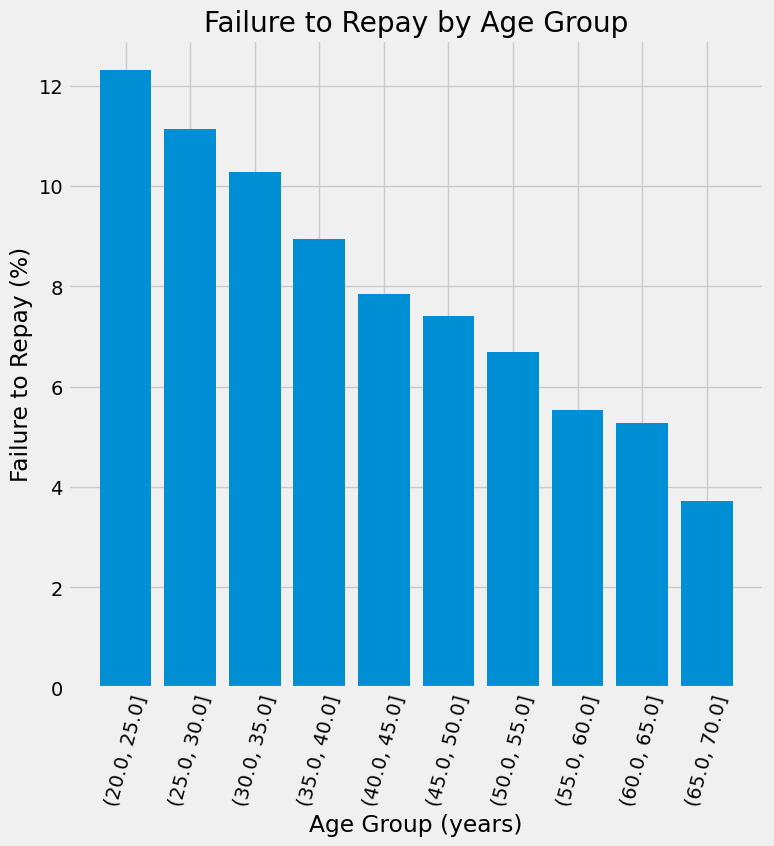

In [50]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

La tendance est claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser leur prêt ! Le taux de non-remboursement est supérieur à 10 % pour les trois tranches d’âge les plus jeunes et inférieur à 5 % pour la tranche d’âge la plus âgée.

Ces informations pourraient être directement utilisées par la banque : comme les jeunes clients sont moins susceptibles de rembourser leur prêt, il faudrait peut-être leur fournir davantage de conseils ou de conseils en matière de planification financière. Cela ne signifie pas que la banque doit faire preuve de discrimination à l’égard des jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour les aider à payer à temps.

Sources extérieures

Les 3 variables ayant les corrélations négatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation, ces caractéristiques représentent un « score normalisé provenant d'une source de données externe ». Je ne sais pas exactement ce que cela signifie, mais il peut s'agir d'une sorte de notation de crédit cumulative réalisée à l'aide de nombreuses sources de données.

Examinons ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles.

In [53]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


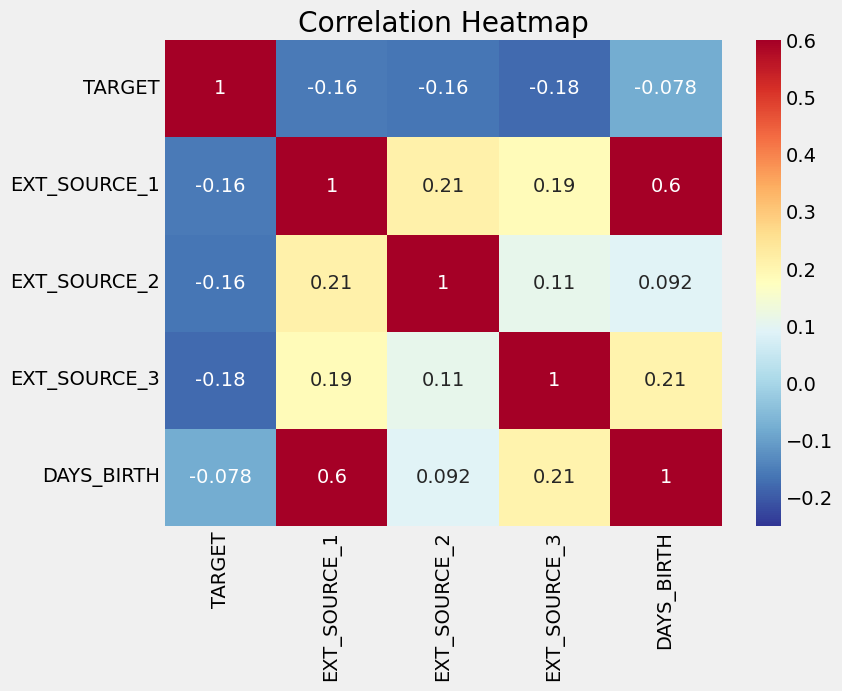

In [54]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique qu'à mesure que la valeur de EXT_SOURCE augmente, le client est plus susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé à EXT_SOURCE_1, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

Nous pouvons ensuite examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

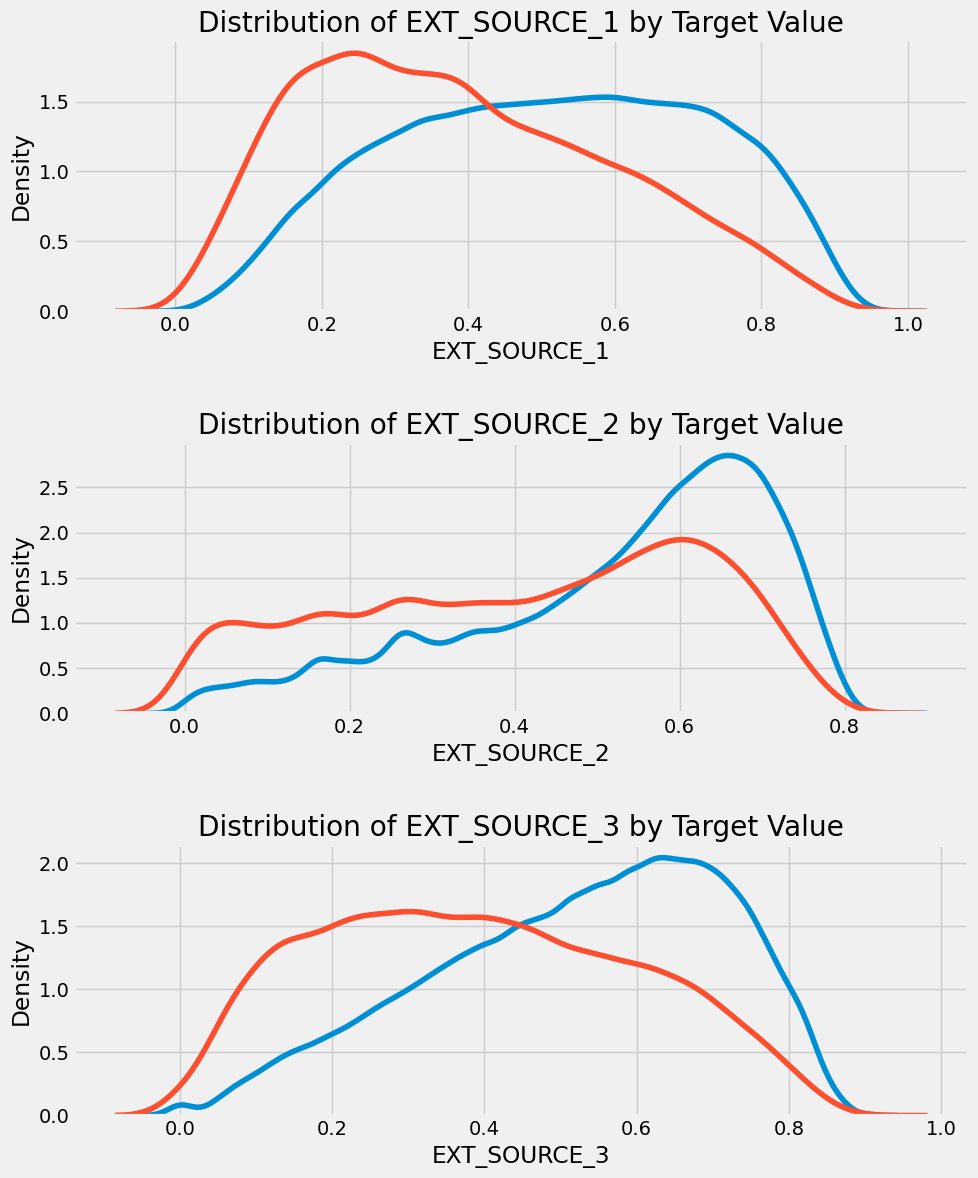

In [56]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles, mais ces variables seront toujours utiles à un modèle d'apprentissage automatique pour prédire si un demandeur remboursera ou non un prêt à temps.

## 3 - Feature engineering

Je m'appuie sur le Kernel : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

On ne reprend pas les transformations de fichier applaction_test qui ne nous concerne pas ici.

J'ai déplacé l'encodage des variables catégorielles après le traitement des valeurs manquantes, pour ne pas fausser les imputations automatiques.

In [59]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

path = "C:/Users/admin/Documents/Projets/Projet_7/data_projet/"

### 3.1 - Pré traiter le fichier application_train

On transforme les variables catégorielles :
- celles avec 2 valeurs en mode binaire
- Celles avec plus que 2 valeurs avec one-hot

Puis on remplace les valeurs aberrantes de la variable DAYS_EMPLOYED vu précédemment.

Puis on crée de nouvelles features en pourcentage

In [61]:
# Preprocess application_train.csv and application_test.csv
def application_train(num_rows = None, nan_as_category = False, path = None):
    # Read data and merge
    df = pd.read_csv(path + 'application_train.csv', nrows= num_rows)
    print("Train samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']        # proportion de la vie d'une personne passée en emploi
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']     # rapport entre le revenu total et le montant du crédit demandé
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] # revenu par membre du foyer
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']   # part du revenu utilisée pour rembourser une annuité
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']                # proportion du crédit remboursée à chaque échéance
    #gc.collect()
    return df

Testons ce pré traitement :

In [63]:
df = application_train(num_rows=10000, path=path)
df.shape

Train samples: 10000


(10000, 127)

In [64]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1

In [65]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
count,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,9.993000e+03,10000.000000,10000.000000,8226.000000,10000.000000,10000.00000,3338.000000,10000.0,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,4353.000000,9974.000000,8005.000000,4935.000000,4184.000000,5120.000000,3360.000000,3021.00000,4691.000000,4994.000000,5057.000000,3205.000000,4102.000000,3155.000000,4991.000000,3058.000000,4522.000000,4935.000000,4184.000000,5120.000000,3360.000000,3021.000000,4691.000000,4994.000000,5057.000000,3205.000000,4102.000000,3155.000000,4991.000000,3058.000000,4522.000000,4935.000000,4184.000000,5120.000000,3360.000000,3021.000000,4691.000000,4994.000000,5057.000000,3205.000000,4102.000000,3155.000000,4991.000000,3058.000000,4522.000000,5187.000000,9958.000000,9958.000000,9958.000000,9958.000000,10000.000000,10000.0,10000.00000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.00000,10000.0,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,8634.000000,8634.000000,8634.000000,8634.000000,8634.000000,8634.000000,8226.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,105831.156800,0.077500,0.416300,1.674489e+05,6.007531e+05,27088.010550,5.403851e+05,0.020898,-16025.273100,-2397.670071,-4986.483900,-2983.38080,11.918514,1.0,0.82250,0.201300,0.99820,0.282100,0.054500,2.156400,2.0472,2.026600,12.07460,0.016400,0.049400,0.038100,0.080400,0.23540,0.180300,0.504268,0.515509,0.511554,0.117371,0.088957,0.979008,0.751310,0.04390,0.077176,0.150640,0.225850,0.231932,0.066957,0.098807,0.107027,0.008408,0.028496,0.113657,0.087932,0.977991,0.757949,0.041366,0.072632,0.146033,0.221740,0.227934,0.065454,0.103099,0.105050,0.007742,0.027394,0.118078,0.088640,0.979014,0.754663,0.044089,0.076811,0.150379,0.22

### 3.2 - Pré traiter les fichiers bureau et bureau_balance

Créons une fonction pour pré-traiter et agrèger les fichiers bureau.csv et bureau_balance.csv pour extraire des caractéristiques utiles.

- bureau.csv contient des informations sur les crédits passés des clients auprès d'autres banques.
- bureau_balance.csv contient l'historique mensuel des statuts des crédits enregistrés dans bureau.csv.

La fonction réalise les actions suivantes :
- Agrégation de bureau_balance.csv par SK_ID_BUREAU
- Agrégation de bureau.csv par SK_ID_CURR
- Séparation entre crédits actifs et clôturés (Création des caractéristiques spécifiques aux crédits actifs et clôturés).

In [67]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True, path = None):
    bureau = pd.read_csv(path + 'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path + 'bureau_balance.csv', nrows = num_rows)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}  # Date la plus ancienne, la plus récente d'un enregistrement, et le nbre d'enregistrements pour un crédit donné
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    #gc.collect()
    
    # Bureau and bureau_balance numeric features
    # agrège toutes les valeurs numériques de chaque client
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations})

    # les nouvelles colonnes auront le préfix BURO
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Séparation entre crédits actifs et clôturés
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    #gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    #gc.collect()
    return bureau_agg

Testons avec ce pré traitement en plus :

In [69]:
df = application_train(num_rows = 10000, path = path)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows = 10000, path = path)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')

df.shape

Train samples: 10000
Bureau df shape: (2011, 81)
Process bureau and bureau_balance - done in 0s


(10000, 208)

In [70]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,...,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_MIN_MIN,ACTIVE_MONTHS_BALANCE_MAX_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,

In [71]:
bureau.head()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_MIN_MIN,ACTIVE_MONTHS_BALANCE_MAX_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053,-2893,-1764,-2287.714286,221585.238095,-2534.0,-648.0,-1519.333333,-1137.571429,0,0.0,NaN,225000.0,92655.642857,648589.50,0.00,0.000000,0.00,0.0,0.000,0.00,NaN,NaN,0,NaN,NaN,NaN,0.0,-2338.0,-2338.0,-2338.000000,NaN,-1958.0,-1958.0,-1958.000000,-1945.000000,0.0,0.0,NaN,48820.5,48820.5000,48820.50,NaN,NaN,0.00,0.0,NaN,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,-2893.0,-1764.0,-2279.333333,265312.266667,-2534.0,-648.0,-1431.6,-1003.00,0.0,0.0,NaN,225000.00,99961.500,599769.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100568,-1274,-207,-493.857143,136769.809524,-969.0,1183.0,110.500000,-244.857143,0,0.0,8178.885,333000.0,119269.877143,834889.14,293535.00,60371.357143,422599.50,0.0,0.000,0.00,13500.0,5887.125,0,NaN,NaN,NaN,0.0,-319.0,-278.0,-292.000000,547.000000,906.0,1183.0,1044.500000,-76.333333,0.0,0.0,NaN,333000.0,186000.0000,558000.00,293535.00,140866.500,422599.50,0.0,0.00,0.00,13500.0,11774.25,0.0,NaN,NaN,NaN,0.0,-1274.0,-207.0,-645.250000,201868.916667,-969.0,-26.0,-356.5,-371.25,0.0,0.0,8178.885,99670.14,69222.285,276889.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
100653,-2474,-182,-1237.571429,986457.952381,-2260.0,3401.0,-295.333333,-536.285714,0,0.0,NaN,315000.0,124783.200000,873482.40,215923.50,65253.060000,456771.42,0.0,0.000,0.00,0.0,0.000,0,NaN,NaN,NaN,0.0,-1564.0,-182.0,-563.500000,446043.666667,-152.0,3401.0,1119.333333,-286.750000,0.0,0.0,NaN,315000.0,181248.7275,724994.91,215923.50,114192.855,456771.42,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,0.0,-2474.0,-1677.0,-2136.333333,169904.333333,-2260.0,-946.0,-1710.0,-869.00,0.0,0.0,NaN,71068.50,49

### 3.3 - Prétraiter le fichier previous_application

Créons une fonction pour prétraiter le fichier previous_application.csv, qui contient des informations sur les demandes de crédit précédentes des clients.

- Remplacement des valeurs spécifiques par NaN
- Création de nouvelles caractéristiques (comme des pourcentages)
- Agrègation les données par SK_ID_CURR (identifiant client) à la fois pour des caractéristiques numériques et catégorielles
- Séparation des demandes approuvées et refusées, puis les agrège séparément

In [73]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True, path = None):
    prev = pd.read_csv(path + 'previous_application.csv', nrows = num_rows)
    
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved']
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS'] == 'Refused']
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    #gc.collect()
    return prev_agg

Testons avec ce pré traitement avec les précédents :

In [75]:
df = application_train(num_rows = 10000, path = path)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows = 10000, path = path)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
with timer("Process previous_applications"):
    prev = previous_applications(num_rows = 10000, path = path)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')

df.shape

Train samples: 10000
Bureau df shape: (2011, 81)
Process bureau and bureau_balance - done in 0s
Previous applications df shape: (9734, 90)
Process previous_applications - done in 0s


(10000, 298)

In [76]:
prev.head()

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_VAR,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_ANNUITY_MIN,REFUSED_AMT_ANNUITY_MAX,REFUSED_AMT_ANNUITY_MEAN,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_APP_CREDIT_PERC_VAR,REFUSED_AMT_DOWN_PAYMENT_MIN,REFUSED_AMT_DOWN_PAYMENT_MAX,REFUSED_AMT_DOWN_PAYMENT_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100009,8996.760,8996.760,8996.760,98239.5,98239.5,98239.5,98239.5,98239.5,98239.5,1.000000,1.000000,1.000000,NaN,0.0,0.0,0.0,98239.5,98239.5,98239.5,18,18,18.0,0.000000,0.000000,0.000000,-449,-449,-449.0,12.0,12.0,8996.760,8996.760,8996.760,98239.5,98239.5,98239.5,98239.5,98239.5,98239.5,1.000000,1.000000,1.000000,NaN,0.0,0.0,0.0,98239.5,98239.5,98239.5,18.0,18.0,18.0,0.000000,0.000000,0.000000,-449.0,-449.0,-449.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100035,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,14,14.0,NaN,NaN,NaN,-138,-138,-138.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,14.0,NaN,NaN,NaN,-138.0,-138.0,-138.0,NaN,0.0
100043,5287.815,5287.815,5287.815,35775.0,35775.0,35775.0,33340.5,33340.5,33340.5,1.073019,1.073019,1.073019,NaN,4500.0,4500.0,4500.0,35775.0,35775.0,35775.0,11,11,11.0,0.129515,0.129515,0.129515,-2411,-2411,-2411.0,8.0,8.0,5287.815,5287.815,5287.815,35775.0,35775.0,35775.0,33340.5,33340.5,33340.5,1.073019,1.073019,1.073019,NaN,4500.0,4500.0,4500.0,35775.0,35775.0,35775.0,11.0,11.0,11.0,0.129515,0.129515,0.129515,-2411.0,-2411.0,-2411.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

### 3.4 - Prétraiter le fichier POS_CASH_balance

Créons une fonction pour rétraiter les données provenant du fichier POS_CASH_balance.csv, qui contient des informations sur l'historique des paiements effectués avec les cartes de crédit ou autres moyens de paiement utilisés par les clients.

- Agrégations statistiques sur des colonnes numériques spécifiques, telles que la valeur maximale, moyenne et la taille de certaines variables.
- Agrègation des informations des colonnes catégorielles avec la moyenne.
- Calcul du nombre de comptes POS par client.

In [78]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True, path = None):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv', nrows = num_rows)   
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    #gc.collect()
    return pos_agg

Testons avec ce pré traitement avec les précédents :

In [80]:
df = application_train(num_rows = 10000, path = path)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows = 10000, path = path)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')  # jointure à gauche avec le dataframe principal
with timer("Process previous_applications"):
    prev = previous_applications(num_rows = 10000, path = path)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')   # jointure à gauche avec le dataframe principal
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows = 10000, path = path)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')   # jointure à gauche avec le dataframe principal

df.shape

Train samples: 10000
Bureau df shape: (2011, 81)
Process bureau and bureau_balance - done in 0s
Previous applications df shape: (9734, 90)
Process previous_applications - done in 0s
Pos-cash balance df shape: (9494, 7)
Process POS-CASH balance - done in 0s


(10000, 305)

In [81]:
pos.head()

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,
100028,-47,-47.0,0,0.0,0,0.0,1
100047,-40,-40.0,0,0.0,0,0.0,1
100165,-44,-44.0,0,0.0,0,0.0,1
100187,-43,-43.0,0,0.0,0,0.0,1
100191,-9,-9.0,0,0.0,0,0.0,1


### 3.5 - Prétraiter le fichier installments_payments

Créons une fonction pour prétraiter le fichier contenant des informations sur les paiements de crédits ou de prêts par les clients.

- Calcul des nouvelles caractéristiques

In [83]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True, path = path):
    ins = pd.read_csv(path + 'installments_payments.csv', nrows = num_rows)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT'] # pourcentage de paiement par rapport à l'annuité
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT'] # Différence entre le paiement effectué et l'annuité
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT'] # Jours de retard (DPD - Days Past Due) et jours avant l'échéance (DBD - Days Before Due)
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT'] 
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0) # Correction des valeurs négatives 
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0) #Correction des valeurs négatives 
    
    # Features: Perform aggregations
    # Agrégation des caractéristiques numériques
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }

    # Application des agrégations par client (SK_ID_CURR)
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    #gc.collect()
    return ins_agg

Testons avec ce pré traitement avec les précédents :

In [85]:
df = application_train(num_rows = 10000, path = path)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows = 10000, path = path)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')  # jointure à gauche avec le dataframe principal
with timer("Process previous_applications"):
    prev = previous_applications(num_rows = 10000, path = path)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')   # jointure à gauche avec le dataframe principal
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows = 10000, path = path)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')   # jointure à gauche avec le dataframe principal
with timer("Process installments payments"):
    ins = installments_payments(num_rows = 10000, path = path)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')

df.shape

Train samples: 10000
Bureau df shape: (2011, 81)
Process bureau and bureau_balance - done in 0s
Previous applications df shape: (9734, 90)
Process previous_applications - done in 0s
Pos-cash balance df shape: (9494, 7)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 24)
Process installments payments - done in 0s


(10000, 329)

In [86]:
ins.head()

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,
100009,1,0.0,0.0,0.0,13.0,13.0,13.0,1.000000,1.000000,1.000000,0.000,0.000,0.000,8821.260,8821.260,8821.260,8821.260,8821.260,8821.260,8821.260,-227.0,-227.0,-227.0,1
100011,1,958.0,958.0,958.0,0.0,0.0,0.0,0.030825,0.030825,0.030825,14138.865,14138.865,14138.865,14588.550,14588.550,14588.550,449.685,449.685,449.685,449.685,-1189.0,-1189.0,-1189.0,1
100012,1,0.0,0.0,0.0,41.0,41.0,41.0,1.000000,1.000000,1.000000,0.000,0.000,0.000,5242.860,5242.860,5242.860,5242.860,5242.860,5242.860,5242.860,-428.0,-428.0,-428.0,1
100035,1,0.0,0.0,0.0,3.0,3.0,3.0,1.000000,1.000000,1.000000,0.000,0.000,0.000,18201.645,18201.645,18201.645,18201.645,18201.645,18201.645,18201.645,-1070.0,-1070.0,-1070.0,1
100042,1,0.0,0.0,0.0,13.0,13.0,13.0,0.965000,0.965000,0.965000,157.500,157.500,157.500,4500.000,4500.000,4500.000,4342.500,4342.500,4342.500,4342.500,-2495.0,-2495.0,-2495.0,1


### 3.6 - Prétraiter le fichier credit_card_balance

Créons une fonction pour prétraiter un fichier contenant des informations sur les cartes de crédit.

- Suppression de la colonne SK_ID_PREV
- Agrégation des données par SK_ID_CURR (ID client), en calculant des statistiques comme le minimum, maximum, moyenne, somme, et variance pour chaque colonne
- Ajout d'une colonne indiquant le nombre de cartes de crédit par client.

In [88]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True, path = path):
    cc = pd.read_csv(path + 'credit_card_balance.csv', nrows = num_rows)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    # Sélectionner uniquement les colonnes numériques
    num_cols = cc.select_dtypes(include=[np.number]).columns
    cc_agg = cc.groupby('SK_ID_CURR')[num_cols].agg(['min', 'max', 'mean', 'sum'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    #gc.collect()
    return cc_agg

Testons avec ce pré traitement avec les précédents :

In [90]:
df = application_train(num_rows = 10000, path = path)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows = 10000, path = path)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')  # jointure à gauche avec le dataframe principal
with timer("Process previous_applications"):
    prev = previous_applications(num_rows = 10000, path = path)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')   # jointure à gauche avec le dataframe principal
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows = 10000, path = path)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')   # jointure à gauche avec le dataframe principal
with timer("Process installments payments"):
    ins = installments_payments(num_rows = 10000, path = path)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')  # jointure à gauche avec le dataframe principal
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows = 10000, path = path)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')  # jointure à gauche avec le dataframe principal

df.shape

Train samples: 10000
Bureau df shape: (2011, 81)
Process bureau and bureau_balance - done in 0s
Previous applications df shape: (9734, 90)
Process previous_applications - done in 0s
Pos-cash balance df shape: (9494, 7)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 24)
Process installments payments - done in 0s
Credit card balance df shape: (9520, 85)
Process credit card balance - done in 0s


(10000, 414)

In [91]:
cc.head()

,CC_SK_ID_CURR_MIN,CC_SK_ID_CURR_MAX,CC_SK_ID_CURR_MEAN,CC_SK_ID_CURR_SUM,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100048,100048,100048,100048.0,100048,-2,-2,-2.0,-2,27302.4,27302.4,27302.4,27302.4,225000,225000,225000.0,225000,27000.0,27000.0,27000.0,27000.0,27000.0,27000.0,27000.0,27000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1458.27,1458.27,1458.27,1458.27,1458.27,1458.27,1458.27,1458.27,25541.73,25541.73,25541.73,25541.73,25956.9,25956.9,25956.9,25956.9,25956.9,25956.9,25956.9,25956.9,1.0,1.0,1.0,1.0,1,1,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,17.0,17.0,17.0,0,0,0.0,0,0,0,0.0,0,1
100059,100059,100059,100059.0,100059,-4,-4,-4.0,-4,0.0,0.0,0.0,0.0,0,0,0.0,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0,0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,1
100135,100135,100135,100135.0,100135,-5,-5,-5.0,-5,0.0,0.0,0.0,0.0,90000,90000,90000.0,90000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0,0,0.0,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.0,0,1
100169,100169,100169,100169.0,100169,-7,-7,-7.0,-7,0.0,0.0,0.0,0.0,405000,405000,405000.0,405000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,0,0,0.0,0,0,0,0.0,0,1
100

### 3.7 - créer le dataframe complet

In [93]:
df = application_train(path = path)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(path = path)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')  # jointure à gauche avec le dataframe principal
with timer("Process previous_applications"):
    prev = previous_applications(path = path)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')   # jointure à gauche avec le dataframe principal
with timer("Process POS-CASH balance"):
    pos = pos_cash(path = path)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')   # jointure à gauche avec le dataframe principal
with timer("Process installments payments"):
    ins = installments_payments(path = path)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')  # jointure à gauche avec le dataframe principal
with timer("Process credit card balance"):
    cc = credit_card_balance( path = path)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')  # jointure à gauche avec le dataframe principal

df.shape

Train samples: 307511
Bureau df shape: (305811, 81)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 90)
Process previous_applications - done in 18s
Pos-cash balance df shape: (337252, 7)
Process POS-CASH balance - done in 13s
Installments payments df shape: (339587, 24)
Process installments payments - done in 44s
Credit card balance df shape: (103558, 85)
Process credit card balance - done in 17s


(307507, 414)

### 3.8 - Traiter les valeurs manquantes

Les algorithmes comme XGBoost et LightGBM peuvent gérer nativement les valeurs manquantes directement, mais le DummyClassifier (pour la baseline), Random Forest, Decision Tree,  et la régression logistique ne le peuvent pas.

Pour comparer les modèles il est préférable de traiter les valeurs manquantes. On pourra toujours ensuite comparer les résultats du XGBoost et du LightGBM sans traitement des valeurs manquantes.

In [95]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(130)

Your selected dataframe has 414 columns.
There are 359 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_APP_CREDIT_PERC_VAR,258350,84.0
CC_AMT_PAYMENT_CURRENT_MAX,246447,80.1
CC_AMT_PAYMENT_CURRENT_MEAN,246447,80.1
CC_AMT_PAYMENT_CURRENT_MIN,246447,80.1


**Regardons combien de lignes resteraient si on supprime les lignes avec au moins une valeur manquante.**

Mais d'abord traitons les colonnes qui ne sont pas marquées comme numériques. Ce sont les variables catégorielles.

In [97]:
# Trouver les colonnes non numériques
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
non_numeric_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

**Regardons combien de colonnes il reste si on supprime les colonnes qui ont plus de 60% de valeurs manquantes.**

In [99]:
threshold = 0.6  # 60% de valeurs manquantes
df_clean = df.loc[:, df.isnull().mean() < threshold]  # Conservation des colonnes avec <60% de NaN
df_clean.shape

(307507, 266)

Intéressant!

In [101]:
# Missing values statistics
missing_values = missing_values_table(df_clean)
missing_values.head(130)

Your selected dataframe has 266 columns.
There are 211 columns that have missing values.


,Missing Values,% of Total Values
LANDAREA_MODE,182588,59.4
LANDAREA_MEDI,182588,59.4
LANDAREA_AVG,182588,59.4
BASEMENTAREA_MEDI,179942,58.5
BASEMENTAREA_MODE,179942,58.5
BASEMENTAREA_AVG,179942,58.5
EXT_SOURCE_1,173376,56.4
NONLIVINGAREA_MODE,169680,55.2
NONLIVINGAREA_AVG,169680,55.2
NONLIVINGAREA_MEDI,169680,55.2


C'est déjà mieux.

**Traitons les valeurs manquantes avec un SimpleImputer**

Le traitement sera différent entre les variables qui sont à l'origine des variables catégorielles, et les variables continues.

In [104]:
# Remplacer Inf par NaN
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Filtrer pour ne garder que les colonnes existantes 
# En effet des colonnes ont été précédemment supprimées car elles avaient trop de valeurs manquantes
non_numeric_cols = list(set(df_clean.columns) & set(non_numeric_cols))

# Déduction des colonnes numériques continues
num_cols = [col for col in df_clean.columns if col not in non_numeric_cols]

# Création des imputers
num_imputer = SimpleImputer(strategy="median")  # Pour les colonnes numériques
cat_imputer = SimpleImputer(strategy="most_frequent")  # Pour les colonnes catégoriques

# Création du ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_imputer, num_cols),
    ('cat', cat_imputer, non_numeric_cols)
])

# Appliquer l'imputation
df_imputed = pd.DataFrame(preprocessor.fit_transform(df_clean), columns=num_cols + non_numeric_cols)

# réappliquer les types corrects pour les colonnes
df_imputed[num_cols] = df_imputed[num_cols].astype(float)
df_imputed[non_numeric_cols] = df_imputed[non_numeric_cols].astype('object')

df_imputed.shape

(307507, 266)

In [105]:
# Missing values statistics
missing_values = missing_values_table(df_imputed)
missing_values.head(130)

Your selected dataframe has 266 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Il n'y a plus de valeurs manquantes, ni de valeurs infinies dans le dataframe.

### 3.11 - Encoder les variables catégorielles

**Créons une fonction pour le one-hot encoding**

Elle prend en entrée un dataframe, et renvoie le dataframe avec les variables de type Object transformée vie one-hot.


In [108]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

**Transformons les variables catégorielles :**
- celles avec 2 valeurs en mode binaire
- Celles avec plus que 2 valeurs avec one-hot

In [110]:
df_imputed.loc[:, ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']].head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,M,N,Y
1,F,N,N
2,M,Y,Y
3,F,N,Y
4,M,N,Y


In [111]:
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df_imputed[bin_feature], uniques = pd.factorize(df_imputed[bin_feature])
    # Convertir les résultats en float
    df_imputed[bin_feature] = df_imputed[bin_feature].astype(float)

In [112]:
df_imputed.loc[:, ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']].head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,0.0,0.0,0.0
1,1.0,0.0,1.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,0.0


In [113]:
df_clean.select_dtypes(include=['object']).head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN


In [114]:
df_imputed.select_dtypes(include=['object']).head()

,NAME_FAMILY_STATUS,NAME_TYPE_SUITE,EMERGENCYSTATE_MODE,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,NAME_INCOME_TYPE,WALLSMATERIAL_MODE,NAME_HOUSING_TYPE,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,Single / not married,Unaccompanied,No,Secondary / secondary special,block of flats,Working,"Stone, brick",House / apartment,Cash loans,WEDNESDAY,Laborers,Business Entity Type 3
1,Married,Family,No,Higher education,block of flats,State servant,Block,House / apartment,Cash loans,MONDAY,Core staff,School
2,Single / not married,Unaccompanied,No,Secondary / secondary special,block of flats,Working,Panel,House / apartment,Revolving loans,MONDAY,Laborers,Government
3,Civil marriage,Unaccompanied,No,Secondary / secondary special,block of flats,Working,Panel,House / apartment,Cash loans,WEDNESDAY,Laborers,Business Entity Type 3
4,Single / not married,Unaccompanied,No,Secondary / secondary special,block of flats,Working,Panel,House / apartment,Cash loans,THURSDAY,Core staff,Religion


In [115]:
# Identifier les colonnes catégorielles
categorical_columns = df_imputed.select_dtypes(include=['object']).columns
print("nombre de colonnes concernées:", len(categorical_columns))

# Création d'un DataFrame vide pour stocker les nouvelles colonnes encodées
df_encoded = df_imputed.drop(columns=categorical_columns)  # On commence par garder les colonnes non catégorielles

# Traitement des colonnes une par une
for col in categorical_columns:
    # On applique pd.get_dummies sur chaque colonne catégorielle
    col_dummies = pd.get_dummies(df_imputed[col], prefix=col, dummy_na=True)
    
    # Ajouter les nouvelles colonnes encodées au DataFrame
    df_encoded = pd.concat([df_encoded, col_dummies], axis=1)

    # Libérer la mémoire après chaque étape
    del col_dummies

# Supprimer les colonnes catégorielles initiales
df_encoded

# Vérifier le résultat
df_encoded.shape

nombre de colonnes concernées: 12


(307507, 395)

In [116]:
df_encoded.select_dtypes(include=['object']).shape

(307507, 0)

Il n'y a plus de colonnes de type 'object'.

In [118]:
df_encoded.shape

(307507, 395)

### 3.12 - Tester SMOTE

**Equilibrons les jeux de données avec SMOTE**

Comme il y a beaucoup plus de prêts remboursés que de prêts non remboursés, il faut rééquilibrer le jeu de données. Pour cela on utilise SMOTE (Synthetic Minority Over-sampling Technique), qui va génèrer des exemples synthétiques pour la classe minoritaire, en créant de nouvelles instances en interpolant entre les exemples existants de la classe minoritaire.

Regardons la distribution de la cible avant le suréchantillonage :

In [120]:
# Définition des features et de la target
X = df_encoded.drop(columns=["TARGET"])  # Features
y = df_encoded["TARGET"]  # Variable cible

<Axes: ylabel='Frequency'>

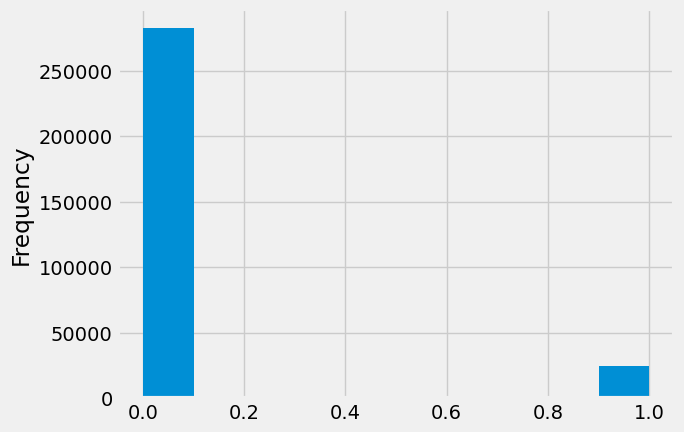

In [121]:
y.plot.hist()

In [122]:
# Initialiser SMOTE
smote = SMOTE(random_state=42)

# Appliquer SMOTE sur les données d'entraînement
X_resampled, y_resampled = smote.fit_resample(X, y)

Regardons la distribution de la cibLe après le suréchantillonage :

<Axes: ylabel='Frequency'>

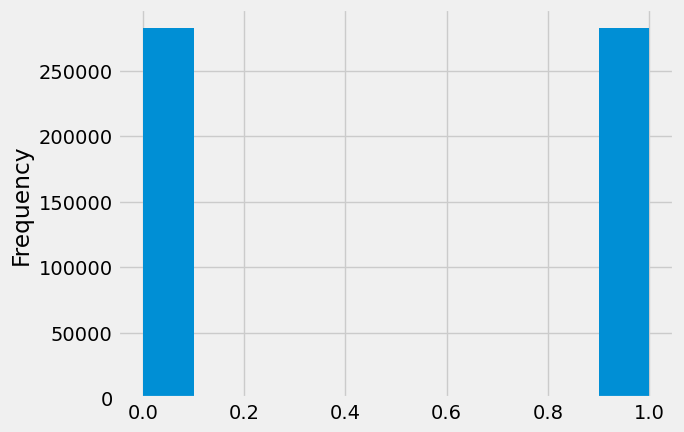

In [124]:
y_resampled.plot.hist()

L'oversampling est une technique utilisée pour résoudre les problèmes de classes déséquilibrées en générant des exemples artificiels de la classe minoritaire. Dans la suite, on utilisera SMOTE en passant par un pipeline, car cela garantit que l'oversampling se fait de manière cohérente, sans provoquer de fuite d'informations entre l'entraînement et la validation.

## 4 - Sauvegarder le résultat du feature engineering

Cette sauvegarde sera reprise directement dans le notebook des simulations.

In [127]:
df_encoded.to_csv('C:/Users/admin/Documents/Projets/Projet_7/data_projet/cleaned/data.csv', index=False)